# Predicting eye tracking features

Eye-tracking data from reading represent an important resource for both linguistics and natural language processing. The ability to accurately model gaze features is crucial to advance our understanding of language processing. On one hand, it can tell us how well our computational models align with human language processing mechanisms. On the other hand, it may provide more accurate models of reading to further psycholinguistic research.

In this tutorial we will first get acquainted with eye tracking data and the structure of the [Zurich Cognitive Language Processing Corpus (ZuCo)](https://www.nature.com/articles/sdata2018291), for which eye movements were recorded during natural reading of English sentences. We use the eye tracking data as is was provided for the [CMCL 2021 Shared Task](https://cmclorg.github.io/shared_task).

Then, we evaluate the ability of a contextualized language model to predict psycholinguistic data, specifically we use transformer models such as BERT and DistilBERT to predict eye tracking features recorded during reading (fixation duration, fixation proportion, etc.). The goal of the task is to predict 5 different token-level eye-tracking metrics from the ZuCo corpus. Finally, we compare the performance of a pre-trained model and a model fine-tuned on eye tracking data.

## Prerequisites

In [1]:
# Install the required pip packages in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy pandas seaborn matplotlib torch transformers spacy

In [2]:
# Import the required libraries
import numpy as np
import pandas as pd
import random
import torch
import transformers
import seaborn as sns
import matplotlib.pyplot as plt

## Loading dataset

In [3]:
# If you are workin on Google Colab, you need to clone the repo to get access to the data files:
#!git clone https://github.com/beinborn/ESSLLI2021.git
# You still need to make sure that the files are under the correct paths!

In [4]:
# Load ZuCo corpus (train, test and gold data files)
training_data = pd.read_csv("data/training_data.csv")
gold_data = pd.read_csv("data/gold_data.csv")

print(len(training_data['sentence_id'].unique()), "training sentences including", len(training_data), "words.")
print(len(gold_data['sentence_id'].unique()), "test sentences including", len(gold_data), "words.")

800 training sentences including 15736 words.
191 test sentences including 3554 words.


## Data analysis

Originally, the ZuCo corpus contains eye tracking data from 30 participants. Here, the data has already been averaged across readers and the feature values have been scaled to a range between 0 and 100. The eye-tracking feature values are scaled to facilitate evaluation via the mean absolute error. The features nFix and fixProp are scaled separately, while FFD, GPT and TRT are scaled together since these are all dependent and measured in milliseconds. The data was randomly shuffled before splitting into training and test data.

In [5]:
# Let's have a look at some sentences and their eye tracking features to get a better idea of the data.
training_data.loc[training_data['sentence_id'] == 444]

# Note: change the sentence_id to see other sentences (0 - 799)

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp
8670,444,0,The,6.896552,1.890099,2.323104,2.323104,41.666667
8671,444,1,original,29.885057,4.323173,5.701227,12.316574,91.666667
8672,444,2,wasn't,28.735632,4.017320,7.096464,10.443658,83.333333
8673,444,3,a,10.344828,2.333414,5.092959,3.484656,50.000000
8674,444,4,good,18.390805,3.690848,4.587787,6.065501,83.333333
8675,444,5,movie,14.942529,3.494965,4.928004,4.842091,83.333333
8676,444,6,but,9.195402,2.343723,3.563696,2.838586,50.000000
8677,444,7,this,9.195402,2.852332,2.852332,3.116946,58.333333
8678,444,8,remake,24.137931,5.900546,6.996804,8.450462,100.000000
8679,444,9,makes,13.793103,3.206296,3.206296,3.793945,83.333333


### Eye tracking features explained

For each word, there are five eye-tracking features:
- _nFix_ (number of fixations): total number of fixations on the current word.
- _FFD_ (first fixation duration): the duration of the first fixation on the prevailing word.
- _GPT_ (go-past time): the sum of all fixations prior to progressing to the right of the current word, including regressions to previous words that originated from the current word.
- _TRT_ (total reading time): the sum of all fixation durations on the current word, including regressions.
- _fixProp_ (fixation proportion): the proportion of participants that fixated the current word (as a proxy for how likely a word is to be fixated).

#### A note on tokenization: 
The tokens in the sentences are split in the same manner as they were presented to the participants during the eye tracking experiments. Hence, this does not necessarily follow a linguistically correct tokenization. For example, the sequences
''(except,'' and ''don't'' were presented as such to the reader and not split into ''('', ''except'', '','' and ''do'', ''n't'' as a tokenizer would do to ensure a more natural way of reading.  
Sentence endings are marked with an \<EOS\> symbol added to the last token.

To get a better idea of the data, let's plot some sentences and their corresponding eye tracking features...

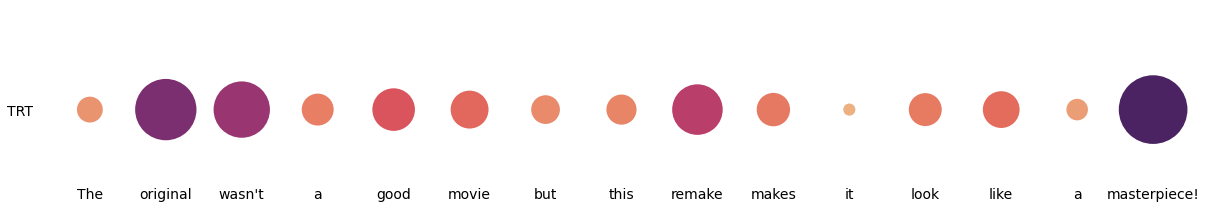

In [6]:
# Visualization: fixation times
# Note: change the sentence_id to see other sentences (0 - 799)
example_sentence = training_data.loc[training_data['sentence_id'] == 444]
fig = plt.figure(figsize=(len(example_sentence)+2,3))
feature_to_draw = "TRT" # or "GPT" or "TRT"
words = [s.replace("<EOS>", "") for s in example_sentence["word"]]
ax = sns.scatterplot(data=example_sentence, x="word_id", y=0, size=feature_to_draw, hue=feature_to_draw, palette="flare", sizes=(200,5000), legend=False)
ax.set_frame_on(False)  
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.xticks(ticks=example_sentence["word_id"], labels=words, fontsize=14)
plt.yticks([0], [feature_to_draw], fontsize=14)
plt.ylim(-0.05,0.07)
plt.xlabel(None)
plt.tight_layout()
plt.show()

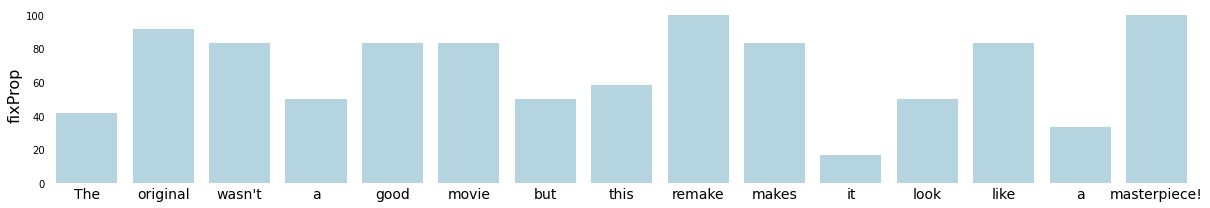

In [7]:
# Visualization: fixation proportion
# Note: change the sentence_id to see other sentences (0 - 799)
example_sentence = training_data.loc[training_data['sentence_id'] == 444]
fig = plt.figure(figsize=(len(example_sentence)+2,3))
feature_to_draw = "fixProp" # or nFix
words = [s.replace("<EOS>", "") for s in example_sentence["word"]]
ax = sns.barplot(data=example_sentence, x="word_id", y="fixProp", color="lightblue")
ax.set_frame_on(False)  
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.xticks(ticks=example_sentence["word_id"], labels=words, fontsize=14)
plt.xlabel(None)
plt.ylabel(feature_to_draw, fontsize=16)
plt.tight_layout()
plt.show()

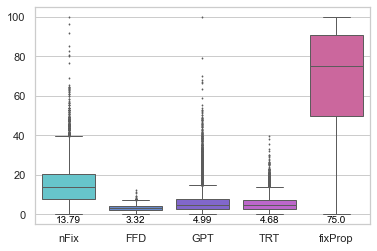

In [8]:
# Now let's get a complete overview of the training data
c = sns.color_palette("hls", 10)
sns.set(font_scale = 1)
sns.set_style("whitegrid")
ax = sns.boxplot(data=training_data[["nFix","FFD","GPT","TRT","fixProp"]], palette=c[5:], color='grey', linewidth=1, fliersize=1)

medians = []
for f in ["nFix","FFD","GPT","TRT","fixProp"]:
    median = training_data[f].median()
    medians.append(median)
median_labels = [str(np.round(s, 2)) for s in medians]

pos = range(len(medians))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], -4, median_labels[tick], #medians[tick] + offsets[tick]
            horizontalalignment='center', size='small', color='black')#, weight='semibold')
plt.show()


## Training model

We compare three state-of-the-art language models trained for English: BERT and DistilBERT. BERT was the first widely successful transformer-based language model and remains
highly influential. DistilBERT is a variant of BERT that requires less training time due to a considerable reduction
of the training parameters while maintaining similar performance on benchmark datasets.
This allows us to analyze if the lighter architectures have an influence on the patterns of eye movements that the models learn.

In [9]:
# import source code for training and evaluating models
import model
import dataloader
import evaluation_metric

Training the model can take a while. It's best to start with a low number of epochs. Alternatively, you can skip the next steps and use the provided models in the "models/" directory:
- A pre-trained DistilBERT model (i.e., fine-tuned for 0 epochs)
- A fine-tuned DistilBERT model (trained for 150 epochs on the eye-tracking data)

In [9]:
# Note: 
# You could load any other BERT or DistilBERT model version available in the Huggingface library in the same manner. 
# DistilBERT was chosen for this tutorial since it has less parameters.

random.seed(12345)
device = torch.device('cpu')
    
# define model
model_name = 'distilbert-base-uncased'
regr_model = model.TransformerRegressionModel(model_name).to(device)
train_data = dataloader.EyeTrackingCSV(training_data, model_name=model_name)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
optimizer = torch.optim.AdamW(regr_model.parameters(), lr=5e-5)
loss = torch.nn.MSELoss()

# train model
# Note: start with 1 or 2 epochs, so find out how long this takes...
# set to 0 or empty list for no fine-tuning?
num_epochs = 5
# is this needed?
print("Starting training...")
for epoch in range(num_epochs):
    model.train(regr_model, train_loader, optimizer, loss)
    print("Epoch:", epoch)
print("Training done.")

# save model
output_model = './models/'+model_name+'_'+str(num_epochs)
torch.save(regr_model, output_model)
print("Model saved to", output_model)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Starting training...
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Training done.
Model saved to ./models/distilbert-base-uncased_5


Note: You can ignore the warning about the model checkpoint...


## Evaluate models

Load pre-trained model and predict eye tracking features



In [10]:
# load pretrained model
pretrained_model_to_evaluate = "models/distilbert-base-uncased_0"
pretrained_model = torch.load(pretrained_model_to_evaluate)

predictions_pretrained = model.predict(pretrained_model, pretrained_model_to_evaluate, gold_data)
predictions_pretrained

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp
0,800,0,It's,0.253211,0.000000,0.000000,0.000000,0.000000
1,800,1,the,0.112046,0.085518,0.000000,0.277517,0.072654
2,800,2,funniest,0.000000,0.023529,0.000000,0.178193,0.000000
3,800,3,American,0.168410,0.342850,0.000000,0.000000,0.000000
4,800,4,comedy,0.000000,0.085266,0.088821,0.008030,0.000000
...,...,...,...,...,...,...,...,...
3549,990,5,pursued,0.028453,0.151943,0.000000,0.000000,0.000000
3550,990,6,a,0.096498,0.360237,0.000000,0.000000,0.000000
3551,990,7,career,0.000000,0.053389,0.000000,0.000000,0.000000
3552,990,8,in,0.184456,0.427278,0.000000,0.000000,0.020954


In [11]:
# load model fine-tuned on eye-tracking data
finetuned_model_to_evaluate = "models/distilbert-base-uncased_150"
finetuned_model = torch.load(finetuned_model_to_evaluate)

predictions_finetuned = model.predict(finetuned_model, finetuned_model_to_evaluate, gold_data)
predictions_finetuned

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp
0,800,0,It's,4.864984,1.313455,1.225597,1.873978,25.046726
1,800,1,the,14.097993,3.091117,4.115786,4.885678,69.069267
2,800,2,funniest,26.642336,4.199001,7.522734,9.354093,89.821472
3,800,3,American,17.835314,4.257764,6.558550,5.846577,92.851906
4,800,4,comedy,17.230507,4.263464,6.342638,5.707375,91.752739
...,...,...,...,...,...,...,...,...
3549,990,5,pursued,29.220915,4.778326,8.007761,10.210065,100.929268
3550,990,6,a,3.244176,1.141124,2.518581,0.948331,24.961500
3551,990,7,career,13.398068,3.853052,8.210123,4.683948,80.521706
3552,990,8,in,3.372766,1.128190,5.845320,1.232182,22.084181


### Baseline

We use the mean central tendency as a baseline for this regression problem, i.e., we calculate the mean value for each feature from the training data and use it as a prediction for all words in the test data.

In [12]:
# compute mean values from training file
features = ["nFix","FFD","GPT","TRT","fixProp"]
mean_feat_values = {}
print("Mean feature values in training data:")
for feat in features:
    avg = np.mean(training_data[feat])
    mean_feat_values[feat] = avg
    print (feat, avg)

# make dataframe of test data with mean values
mean_data = gold_data.copy()
for feat in features:
    mean_data[feat] = mean_feat_values[feat]

Mean feature values in training data:
nFix 15.1017782748365
FFD 3.1910228250548047
GPT 6.345511205701235
TRT 5.309609916601204
fixProp 67.05723394392223


### Evaluation metric: Mean absolute error

Now that we have the predictions of the mean baseline as well as a pre-trained and a fine-tuned model, we can calculate the resutss. The model performance is evaluated by using the _mean absolute error_ metric (MAE), meaning that we average over the error of all samples in the test set:

$MAE = \frac{\sum_{i=1}^{n} | y_{i} - x_{i}|}{n} $




Results pre-trained model:
MAE for nFix: 15.087638004183914
MAE for FFD: 2.9985058935006013
MAE for GPT: 6.3720704862735795
MAE for TRT: 5.256835941134088
MAE for fixProp: 67.01796054929119
Overall MAE: 19.346602174876672


Results fine-tuned model:
MAE for nFix: 4.3378435708878325
MAE for FFD: 0.7026542748697112
MAE for GPT: 2.5579450948635043
MAE for TRT: 1.6773681869889472
MAE for fixProp: 11.880517177967716
Overall MAE: 4.2312656611155415


Results mean baseline:
MAE for nFix: 7.302784572412885
MAE for FFD: 1.1491256623904909
MAE for GPT: 3.781862596034746
MAE for TRT: 2.777713539662726
MAE for fixProp: 21.77547317917012
Overall MAE: 7.357391909934194




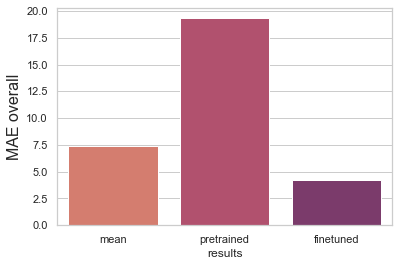

In [13]:
# Calculate mean absolute error on the predictions
print("Results pre-trained model:")
mae_pretrained = evaluation_metric.evaluate(predictions_pretrained, gold_data)
print("Results fine-tuned model:")
mae_finetuned = evaluation_metric.evaluate(predictions_finetuned, gold_data)
print("Results mean baseline:")
mae_mean = evaluation_metric.evaluate(mean_data, gold_data)

data = pd.DataFrame(data={'results': ["mean", "pretrained", "finetuned"], 'mae': [mae_mean, mae_pretrained, mae_finetuned]})
ax = sns.barplot(x="results", y="mae", data=data, palette="flare")
ax.set_ylabel('MAE overall', fontsize=16)
plt.show()

As the numbers and the plot show, the pre-trained model that is not trained on eye-tracking features but purely on text, does not beat the mean baseline. However, the model fine-tuned on eye-tracking data is substantially better (i.e., lower MAE) than the baseline.

Based on these results, we can conclude that the difficulty of predicting the individual eye-tracking features is analogous in all models: FFD is the most accurately predicted feature. This seems to suggest that the models are more capable to capture early processing stages of lexical access compared to late-stage semantic integration, represented by TRT and nFix.

Generally, the error for the three features representing reading times in milliseconds (FFD, GPT, and TRT), is much lower than for nFix and fixProp. The latter are the features with the most variance. The mean baseline results also reveal the same patterns. The features with lower variance achieve lower MAEs. The fixProp feature, representing how likely a word is to be fixated, might be more challenging to predict since it is more dependent on subject-specific characteristics.

### Visualization of predictions

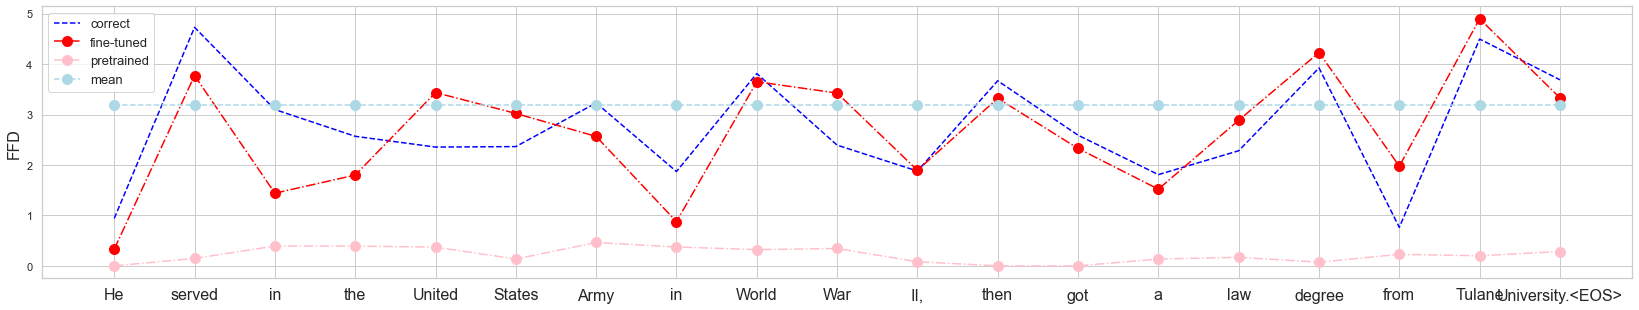

In [14]:
# plot a sentence with real eye tracking data and the corresponding model predictions
sentence_to_plot = 953 #801, 901, 950, 953
feature_to_plot = "FFD"

true_sentence = gold_data.loc[gold_data['sentence_id'] == sentence_to_plot]
predicted_sentence_finetuned = predictions_finetuned.loc[predictions_finetuned['sentence_id'] == sentence_to_plot]
predicted_sentence_pretrained = predictions_pretrained.loc[predictions_pretrained['sentence_id'] == sentence_to_plot]

# todo: change fig size accroding to sent length
fig, ax = plt.subplots(1,1,figsize=(len(true_sentence)*1.5,5))
ax.plot(list(range(len(true_sentence))), true_sentence[feature_to_plot], label="correct", color="blue", linestyle="--")
ax.plot(list(range(len(predicted_sentence_finetuned))), predicted_sentence_finetuned[feature_to_plot], label="fine-tuned", color="red", marker='o', ms=10, linestyle="-.")
ax.plot(list(range(len(predicted_sentence_pretrained))), predicted_sentence_pretrained[feature_to_plot], label="pretrained", color="pink", marker='o', ms=10, linestyle="-.")

# todo: add mean as a task
ax.plot(list(range(len(predicted_sentence_pretrained))), [mean_feat_values[feature_to_plot]]*len(predicted_sentence_pretrained), label="mean", color="lightblue", marker='o', ms=10, linestyle="--")

ax.set_ylabel(feature_to_plot, fontsize=16)
ax.set_xticks(list(range(len(true_sentence))))
ax.set_xticklabels(true_sentence['word'], fontsize=16)
ax.legend(fontsize=13)
plt.show()

### Part of Speech Analysis

Now we have both evaluated the aggregated performance of the models as well as looked at the predictions for specific sentences. Next, we want to analyze whether there are certain parts of speech (PoS) for which eye tracking features are more easily predictable than others.

Therefore, we first use the SpaCy part-of-speech tagger to get the PoS tags for the sentence in our test data: 

In [15]:
# load English SpaCy model
import spacy
!python3 -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

# making sure Spacy doesn't mess with out tokenization
from spacy.tokens import Doc
def custom_tokenizer(wordlist):
    """replace spacy tokenizer with already tokenized list of words"""
    return Doc(nlp.vocab, words=wordlist, spaces=None)

nlp.tokenizer = custom_tokenizer

     |████████████████████████████████| 13.6 MB 4.9 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [16]:
# tag the data and add the tags to the dataframe
def pos_tag(data_to_tag):
    words = [str(w).replace("<EOS>", ".") for w in data_to_tag['word']]
    tagged_sents = nlp(words)
    data_to_tag['pos_tags'] = [token.pos_ for token in tagged_sents]

    return data_to_tag

tagged_data = pos_tag(gold_data)
tagged_predictions = pos_tag(predictions_finetuned)

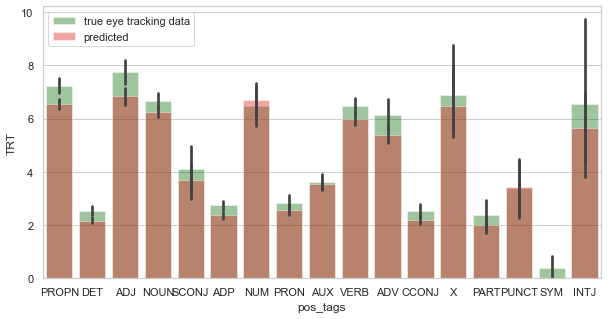

In [17]:
feature_to_plot = "TRT"

#fig = plt.figure(figsize=(10,5))
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.barplot(x="pos_tags", y=feature_to_plot, data=tagged_data, color="green", label="true eye tracking data", alpha=0.4)
sns.barplot(x="pos_tags", y=feature_to_plot, data=tagged_predictions, color="red", label="predicted", alpha=0.4)
plt.legend()
plt.show()

If you are interested in seeing how good these results are compared to the systems participating in the Shared Task, have a look at Table 3 of [this paper](https://aclanthology.org/2021.cmcl-1.7.pdf).


## Additional exercises
- Can you change the code to fine-tune a BERT model instead of DistilBert?
- What additional linguistic analyses can you implement to analyze the predictions?
- What could you do to improve the models?